<a href="https://colab.research.google.com/github/PChabelski/yahooHockeyFantaPy/blob/main/hockey_FantaPy_normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this at the beginning to set up the libaries and security links
!pip install yahoo-fantasy-api
!pip install -U -q PyDrive
# import libraries
import pandas as pd, numpy as np, copy
from math import sqrt, log, exp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA

import yahoo_oauth
from yahoo_oauth import OAuth2
import yahoo_fantasy_api as yfa
import json

# Access csv file from Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/drive')
# These are from my personal API Token with the Yahoo site
creds = {'consumer_key': 'dj0yJmk9elVQcHZ2RTBMWGlBJmQ9WVdrOVUwRkpkazFGU1ZjbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWY4', 'consumer_secret': '8cb89479045212bcf8892d6e0fbbb96cf2acfe51'}
with open('oauth2.json', "w") as f:
   f.write(json.dumps(creds))
oauth = OAuth2(None, None, from_file='oauth2.json')

  Created wheel for yahoo-fantasy-api: filename=yahoo_fantasy_api-2.4.1-cp37-none-any.whl size=24872 sha256=d1c7652892f4d1ea68945444eb64c7bf192baf12d84f90e37a1d7ea73c9e4a2f
  Stored in directory: /root/.cache/pip/wheels/f7/df/02/07e80f27d16a241a6f572d121227911c334892f4a53b3c3241
  Created wheel for yahoo-oauth: filename=yahoo_oauth-1.1-cp37-none-any.whl size=7274 sha256=08b6aae0b7c511c1d4b039c60f48652fe0138d9b8c1ee278b0b7aee9e00d7b3d
  Stored in directory: /root/.cache/pip/wheels/f5/dd/85/e75db76ad7c7c1d0db74de910f1383dfb37421288b1a0d96e4
  Created wheel for rauth: filename=rauth-0.7.3-cp37-none-any.whl size=16080 sha256=0ce1d301af99cd947e5ad4a29c1751c72a8063d00bfe9e86b1b436b16ee92e7d
  Stored in directory: /root/.cache/pip/wheels/7b/94/5d/81afc278dd5da884a0002563dc4b0fe85f9067a5a40f76f858
Successfully built yahoo-fantasy-api yahoo-oauth rauth


[2021-06-08 22:25:12,490 DEBUG] [google.auth._default._default._get_explicit_environ_credentials] Checking None for explicit credentials as part of auth process...
[2021-06-08 22:25:12,490 DEBUG] [google.auth._default._default._get_explicit_environ_credentials] Checking None for explicit credentials as part of auth process...
[2021-06-08 22:25:12,496 DEBUG] [google.auth._default._default._get_gcloud_sdk_credentials] Checking Cloud SDK credentials as part of auth process...
[2021-06-08 22:25:12,496 DEBUG] [google.auth._default._default._get_gcloud_sdk_credentials] Checking Cloud SDK credentials as part of auth process...
[2021-06-08 22:25:12,501 DEBUG] [google.auth._default._default._get_gcloud_sdk_credentials] Cloud SDK credentials not found on disk; not using them
[2021-06-08 22:25:12,501 DEBUG] [google.auth._default._default._get_gcloud_sdk_credentials] Cloud SDK credentials not found on disk; not using them
[2021-06-08 22:25:12,508 DEBUG] [google.auth._default._default._get_gae_cred

Mounted at /drive
Enter verifier : n7vs7wn


In [ ]:
 weekDf['Goals']

24      9
49      9
96     11
121    10
190     5
237     7
262    15
287    15
Name: Goals, dtype: object

In [ ]:
def normFunc(inputColumn):
  #print(inputColumn)
  maxVal = inputColumn.max()
  minVal = inputColumn.min()
  #print('Max: ', maxVal)
  #print('Min: ', minVal)
  try:
    normedColumn = (inputColumn - minVal)/(maxVal - minVal)
    #print(normedColumn)
  except ZeroDivisionError:
    print('All zeros')
    normedColumn = inputColumn.rank(pct=True) # revert to original ranking

  return normedColumn

In [ ]:
normFunc(weekDf['Goals'])

14     0.0714286
29             1
44      0.214286
71      0.571429
86      0.428571
101            0
116     0.285714
215    0.0714286
Name: Goals, dtype: object

In [ ]:
# GENERAL RUN ###########################################################################
gm = yfa.Game(oauth,'nhl')
#yearsToCheck = [2020]
#yearsToCheck = [2019,2020]
#yearsToCheck = [2018,2019,2020]
yearsToCheck = [2020,2019,2018,2017,2016,2015,2014,2013]
#yearsToCheck = [2013]
# 2013 is the last year before the scoring was vastly different
# NOTE - anything 2017 and before will break, something to do with missing goalie stats... -> Niko didn't start any skater in week 23

finalDf = pd.DataFrame()
finalfinalDf = pd.DataFrame()
  
outputDf = pd.DataFrame()

for year in yearsToCheck:
  mainDf = pd.DataFrame()

  print('Year:',year)
  yearValue = gm.league_ids(year=year)
  currentLeague = gm.to_league(str(yearValue[0]))
  maxWeeks = currentLeague.current_week()
  if year == 2020:
    maxWeeks -= 0 # don't count the current week if running the script 
  for week in range(1,maxWeeks+1):
    print('WEEK: ', week)
    currentMatchups = currentLeague.matchups(week)
    generalInfo = currentMatchups["fantasy_content"]["league"][0]
    matchupsList = currentMatchups["fantasy_content"]["league"][1]["scoreboard"]['0']['matchups']   

    columnIDs = ['Year', 'Week', 'Team Name', 'GM Name', 'Opponent Name','Yahoo Team ID', 'Days In Week','Week Start Date', 'Matchup ID', 'faab_balance', 'NumberOfMoves', 'NumberOfTrades','Division','Waiver Priority','Playoffs','Keeper League','Defaulted Week',
                'Games Played','Games Remaining','Goals','Assists','PlusMinus','PIM','PPP','SHP','GWG','SOG','Hits','Blocks','Wins','Losses','Saves','Save%','Shutouts','Week_YahooScore','Week_Points']


    if year == 2017: # this is the year we had 20 people
      matchupID = [0,1,2,3,4,5,6,7,8,9]
    elif year == 2015 or year == 2014: # this is the year we had 14 people
      matchupID = [0,1,2,3,4,5,6]
    elif year == 2013: # only 12 people
      matchupID = [0,1,2,3,4,5]
    else: # all other years
      matchupID = [0,1,2,3,4,5,6,7] 


    if year == 2020 or year == 2019 or year == 2018:
      keeperLeague = 1
    else:
      keeperLeague = 0

    for i in matchupID:  # cycle through all the matchups in the week
      #print('Matchup ID:',i)
      try:
        i_str = str(i)
        weekMatchup = matchupsList[i_str]
        for j in range(0,2):  # cycle through both teams
          j_str = str(j)  
          season = generalInfo['season']
          current_week = week
          teamName = weekMatchup['matchup']['0']['teams'][j_str]['team'][0][2]['name']
          opponent = weekMatchup['matchup']['0']['teams'][str(abs(j-1))]['team'][0][2]['name']
          gmName = weekMatchup['matchup']['0']['teams'][j_str]['team'][0][19]['managers'][0]['manager']['nickname']
          daysInWeek = (currentLeague.week_date_range(current_week)[1] - currentLeague.week_date_range(current_week)[0]).days +1
          weekStart = currentLeague.week_date_range(current_week)[0] 
          matchupID = i+1
          teamKey = weekMatchup['matchup']['0']['teams'][j_str]['team'][0][0]['team_key']
          opponentKey = weekMatchup['matchup']['0']['teams'][str(abs(j-1))]['team'][0][0]['team_key'] 
          if season == '2019' or season == '2020': 
            faab_balance = weekMatchup['matchup']['0']['teams'][j_str]['team'][0][8]['faab_balance']
          else: #No FAAB here
            faab_balance = '' 
          
          movesMade = weekMatchup['matchup']['0']['teams'][j_str]['team'][0][11]['roster_adds']['value']
          tradesMade = weekMatchup['matchup']['0']['teams'][j_str]['team'][0][10]['number_of_trades']

          # stats
          goals = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][0]['stat']['value']
          assists = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][1]['stat']['value']
          plusminus = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][2]['stat']['value']
          pim = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][3]['stat']['value']
          ppp = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][4]['stat']['value']    
          shp = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][5]['stat']['value']
          gwg = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][6]['stat']['value']
          sog = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][7]['stat']['value']
          hit = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][8]['stat']['value']
          blk = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][9]['stat']['value']
         
          if season == '2019' or season == '2020':  # GAA intead of losses & shift everything slighly to the right by 1 element
            wins = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][10]['stat']['value']
            losses = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][11]['stat']['value']
            saves = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][12]['stat']['value']
            savepercent = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][14]['stat']['value']
            shutout = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][15]['stat']['value']
          else: # Losses instead of GAA, shift some things slightly over to the right by 1 element
            wins = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][10]['stat']['value']
            losses = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][12]['stat']['value']
            saves = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][13]['stat']['value']
            savepercent = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][15]['stat']['value']
            shutout = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_stats']['stats'][16]['stat']['value']

          # CHECK FOR MISSING SKATER/GOALIE STARTS
          # IN CASE SOMEONE RAGED OR WAS LAZY

          defaultedWeek = 0
          # 2017 Niko Playoff case - ragequit and didn't start a single skater
          try: 
            plusminus = float(plusminus)
          except ValueError:
            print('NO SKATER STARTS FOUND - RAGEQUIT WEEK')
            goals = -1
            assists = -1
            plusminus = -34 # one more than the worst ever recorded value
            pim = -1
            ppp = -1 
            shp = -1
            gwg = -1
            sog = -1
            hit = -1
            blk = -1
            print('Week: ', current_week)
            print('Players in matchup: ')
            print(teamName)
            print(opponent)
            current_week = week
            defaultedWeek = 1
          # check if there was an instance of a team not meeting the required goalie starts
          try:
            wins = float(wins)
            losses = float(losses)
            saves = float(saves)
            savepercent = float(savepercent)
            shutout = float(shutout)
          except ValueError:
            print('!!!!POTENTIALLY MISSING GOALIE STATS!!!!')
            wins = -1
            losses = 10 # higher than any of the max losses ever recorded
            saves = -1
            savepercent = -0.01
            shutout = -1
            print('Week: ', current_week)
            print('Players in matchup: ')
            print(teamName)
            print(opponent)
            current_week = week
            defaultedWeek = 1



          # misc
          gamesPlayed = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_remaining_games']['total']['completed_games']
          gamesRemaining = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_remaining_games']['total']['remaining_games']
          yahooScore = weekMatchup['matchup']['0']['teams'][j_str]['team'][:][1]['team_points']['total']
          yahooPoints = 2*int(yahooScore) + (30 - (2*int(yahooScore) + 2*int(weekMatchup['matchup']['0']['teams'][str(abs(j-1))]['team'][:][1]['team_points']['total'])))/2  # need to account for opponent scores to get the tie values

          if season == '2020': #Only 1 division
            division = 1 # THUNDERDOMMME
          else:
            division = weekMatchup['matchup']['0']['teams'][j_str]['team'][0][6]['division_id']
          waiverPriority = weekMatchup['matchup']['0']['teams'][j_str]['team'][0][7]['waiver_priority']
          isPlayoffs = weekMatchup['matchup']['is_playoffs']

          stats = [season, current_week, teamName, gmName,opponent,teamKey,daysInWeek,weekStart,matchupID,faab_balance,movesMade,tradesMade,division,waiverPriority,isPlayoffs,keeperLeague,defaultedWeek,
                  float(gamesPlayed),
                  float(gamesRemaining),
                  float(goals),
                  float(assists),
                  float(plusminus),
                  float(pim),
                  float(ppp),
                  float(shp),
                  float(gwg),
                  float(sog),
                  float(hit),
                  float(blk),
                  float(wins),
                  float(losses),
                  float(saves),
                  float(savepercent),
                  float(shutout),yahooScore, yahooPoints]

          mainDf = mainDf.append(pd.DataFrame(stats).T)

      except KeyError:
        pass

  mainDf.columns = columnIDs
  mainDf

  ## ===========================================================================
  ## RUN FOR THE ADVANCED WEEKLY STUFF
  ## =========================================================================== 
  pd.options.mode.chained_assignment = None  # default='warn'
  for year in mainDf.Year.unique():
    yearDf = mainDf[(mainDf['Year'] == year)]
    for week in mainDf.Week.unique():
      weekDf = yearDf[(yearDf['Week'] == week)]
      # weekDf['Goals Rank'] = weekDf['Goals'].rank(pct=True)
      # weekDf['Assists Rank'] = weekDf['Assists'].rank(pct=True)
      # weekDf['PlusMinus Rank'] = weekDf['PlusMinus'].rank(pct=True)
      # weekDf['PIM Rank'] = weekDf['PIM'].rank(pct=True)
      # weekDf['PPP Rank'] = weekDf['PPP'].rank(pct=True)
      # weekDf['SHP Rank'] = weekDf['SHP'].rank(pct=True)
      # weekDf['GWG Rank'] = weekDf['GWG'].rank(pct=True)
      # weekDf['SOG Rank'] = weekDf['SOG'].rank(pct=True)
      # weekDf['Hits Rank'] = weekDf['Hits'].rank(pct=True)
      # weekDf['Blocks Rank'] = weekDf['Blocks'].rank(pct=True)
      # weekDf['Wins Rank'] = weekDf['Wins'].rank(pct=True)
      # weekDf['Losses Rank'] = 1-weekDf['Losses'].rank(pct=True)
      # weekDf['Saves Rank'] = weekDf['Saves'].rank(pct=True)
      # weekDf['Save% Rank'] = weekDf['Save%'].rank(pct=True)
      # weekDf['Shutouts Rank'] = weekDf['Shutouts'].rank(pct=True)


      weekDf['Goals Rank'] = normFunc(weekDf['Goals'])
      weekDf['Assists Rank'] = normFunc(weekDf['Assists'])
      weekDf['PlusMinus Rank'] = normFunc(weekDf['PlusMinus'])
      weekDf['PIM Rank'] = normFunc(weekDf['PIM'])
      weekDf['PPP Rank'] = normFunc(weekDf['PPP'])
      weekDf['SHP Rank'] = normFunc(weekDf['SHP'])
      weekDf['GWG Rank'] = normFunc(weekDf['GWG'])
      weekDf['SOG Rank'] = normFunc(weekDf['SOG'])
      weekDf['Hits Rank'] = normFunc(weekDf['Hits'])
      weekDf['Blocks Rank'] = normFunc(weekDf['Blocks'])
      weekDf['Wins Rank'] = normFunc(weekDf['Wins'])
      weekDf['Losses Rank'] = normFunc(1-weekDf['Losses'])
      weekDf['Saves Rank'] = normFunc(weekDf['Saves'])
      weekDf['Save% Rank'] = normFunc(weekDf['Save%'])
      weekDf['Shutouts Rank'] = normFunc(weekDf['Shutouts'])



      # Personal Week Score calculation
      weekDf['Personal Week Score'] = (weekDf['Goals Rank'] + 
      weekDf['Assists Rank'] +
      weekDf['PlusMinus Rank'] +
      weekDf['PIM Rank'] +
      weekDf['PPP Rank'] +
      weekDf['SHP Rank'] +
      weekDf['GWG Rank'] +
      weekDf['SOG Rank'] +
      weekDf['Hits Rank'] +
      weekDf['Blocks Rank'] +
      weekDf['Wins Rank'] +
      weekDf['Losses Rank'] +
      weekDf['Saves Rank'] +
      weekDf['Save% Rank'] +
      weekDf['Shutouts Rank'])

      weekDf['Yahoo_Points_Rank'] = normFunc(weekDf['Week_Points']) # How massive your score was (15, 14, 13... 3, 2, 1, 0)
      
      for matchup in weekDf['Matchup ID'].unique():
        matchupDf = weekDf[(weekDf['Matchup ID'] == matchup)]
        matchupDf['Matchup Week Score'] = sum(matchupDf['Personal Week Score'])
        matchupDf['Goals Win'] = ((sum(matchupDf['Goals'])-matchupDf['Goals']) <= matchupDf['Goals']).astype(int)
        matchupDf['Assists Win'] = ((sum(matchupDf['Assists'])-matchupDf['Assists']) <= matchupDf['Assists']).astype(int)
        matchupDf['PlusMinus Win'] = ((sum(matchupDf['PlusMinus'])-matchupDf['PlusMinus']) <= matchupDf['PlusMinus']).astype(int)
        matchupDf['PIM Win'] = ((sum(matchupDf['PIM'])-matchupDf['PIM']) <= matchupDf['PIM']).astype(int)
        matchupDf['PPP Win'] =((sum(matchupDf['PPP'])-matchupDf['PPP']) <= matchupDf['PPP']).astype(int) 
        matchupDf['SHP Win'] =  ((sum(matchupDf['SHP'])-matchupDf['SHP']) <= matchupDf['SHP']).astype(int) 
        matchupDf['GWG Win'] = ((sum(matchupDf['GWG'])-matchupDf['GWG']) <= matchupDf['GWG']).astype(int) 
        matchupDf['SOG Win'] = ((sum(matchupDf['SOG'])-matchupDf['SOG']) <= matchupDf['SOG']).astype(int) 
        matchupDf['Hits Win'] = ((sum(matchupDf['Hits'])-matchupDf['Hits']) <= matchupDf['Hits']).astype(int) 
        matchupDf['Blocks Win'] = ((sum(matchupDf['Blocks'])-matchupDf['Blocks']) <= matchupDf['Blocks']).astype(int)
        matchupDf['Wins Win'] = ((sum(matchupDf['Wins'])-matchupDf['Wins']) <= matchupDf['Wins']).astype(int) 
        matchupDf['Losses Win'] =  ((sum(matchupDf['Losses'])-matchupDf['Losses']) > matchupDf['Losses']).astype(int)  # Flip the convention for Losses & GAA (you want the lower score)
        matchupDf['Saves Win'] = ((sum(matchupDf['Saves'])-matchupDf['Saves']) <= matchupDf['Saves']).astype(int)
        matchupDf['Save% Win'] =  ((sum(matchupDf['Save%'])-matchupDf['Save%']) <= matchupDf['Save%']).astype(int)
        matchupDf['Shutouts Win'] = ((sum(matchupDf['Shutouts'])-matchupDf['Shutouts']) <= matchupDf['Shutouts']).astype(int) 
        matchupDf['Week Win'] =  ((sum(matchupDf['Week_Points'])-matchupDf['Week_Points']) <= matchupDf['Week_Points']).astype(int) 

        matchupDf['Opponent Power Score'] = matchupDf['Matchup Week Score'] - matchupDf['Personal Week Score']
        matchupDf['Weighted Power Score'] = (0.9* matchupDf['Personal Week Score']) + (0.075*matchupDf['Opponent Power Score']) + (0.025*matchupDf['Yahoo_Points_Rank'])
        finalDf = pd.concat([finalDf,matchupDf],ignore_index=True)


  #finalDf = pd.concat([mainDf, totalWeekDf], axis=1).reindex(mainDf.index)
  #print(finalDf)
  # ==================================================================
  # === Section for cross-week breakdown ============================

  #for year in finalDf['Year'].unique():
  print('Analyzing year:', year)
  yearDf = finalDf[finalDf['Year'] == year]
  finalfinalDf = pd.DataFrame()
  for team in yearDf['Team Name'].unique():  # Filter by team
    #print('Analyzing team: ' + team + ' in year: ' + year) 
    teamDf = yearDf[yearDf['Team Name'] == team]
    for teamWeek in teamDf.Week.unique():    # then parse the weeks
      teamWeekDf = teamDf[teamDf['Week'] == teamWeek]
      if teamWeek == 1:
        #print('WEEK 1')
        thisWeek = teamWeekDf['Weighted Power Score']
        weekScore = thisWeek
        teamWeekDf['FINAL POWER SCORE'] = weekScore
        finalfinalDf = pd.concat([finalfinalDf,teamWeekDf],ignore_index=True)
      if teamWeek >= 2:
        #print('WEEK 2')
        allWeeks = (sum(teamDf[teamDf['Week'] <= teamWeek]['Weighted Power Score'].values))/(teamWeek)
        #print(teamDf[teamDf['Week'] <= teamWeek]['Weighted Power Score'])
        #print('AVERAGE: ', allWeeks)
        weekScore = allWeeks
        teamWeekDf['FINAL POWER SCORE'] = weekScore
        finalfinalDf = pd.concat([finalfinalDf,teamWeekDf],ignore_index=True)

  for week in finalfinalDf['Week'].unique():
    weekDf = finalfinalDf[finalfinalDf['Week'] == int(week)]
    weekDf['WEEK POWER RANK'] = (17-weekDf['FINAL POWER SCORE'].rank(method='max').values)
    

    outputDf = pd.concat([outputDf,weekDf],ignore_index=True)



  print('YEAR COMPLETE')

print('RUN COMPLETE')
print('Final DF:')
print(outputDf)



Year: 2020
WEEK:  1
WEEK:  2
WEEK:  3
WEEK:  4
WEEK:  5
WEEK:  6
WEEK:  7
WEEK:  8
WEEK:  9
WEEK:  10
WEEK:  11
WEEK:  12
WEEK:  13
WEEK:  14
WEEK:  15


[2021-06-08 22:29:45,055 INFO] [numexpr.utils.utils._init_num_threads] NumExpr defaulting to 2 threads.


All zeros
Analyzing year: 2020
YEAR COMPLETE
Year: 2019
WEEK:  1
WEEK:  2
WEEK:  3
WEEK:  4
WEEK:  5
WEEK:  6
WEEK:  7
WEEK:  8
WEEK:  9
WEEK:  10
WEEK:  11
WEEK:  12
WEEK:  13
WEEK:  14
WEEK:  15
WEEK:  16
WEEK:  17
WEEK:  18
WEEK:  19
WEEK:  20
Analyzing year: 2019
YEAR COMPLETE
Year: 2018
WEEK:  1
WEEK:  2
WEEK:  3
WEEK:  4
WEEK:  5
WEEK:  6
WEEK:  7
WEEK:  8
WEEK:  9
WEEK:  10
WEEK:  11
WEEK:  12
WEEK:  13
WEEK:  14
WEEK:  15
WEEK:  16
WEEK:  17
WEEK:  18
!!!!POTENTIALLY MISSING GOALIE STATS!!!!
Week:  18
Players in matchup: 
Robidas' Islanders
I Am The Senate-ors
WEEK:  19
WEEK:  20
WEEK:  21
WEEK:  22
WEEK:  23
WEEK:  24
All zeros
All zeros
Analyzing year: 2018
YEAR COMPLETE
Year: 2017
WEEK:  1
WEEK:  2
WEEK:  3
WEEK:  4
WEEK:  5
WEEK:  6
WEEK:  7
WEEK:  8
WEEK:  9
WEEK:  10
WEEK:  11
WEEK:  12
WEEK:  13
WEEK:  14
WEEK:  15
WEEK:  16
WEEK:  17
WEEK:  18
WEEK:  19
WEEK:  20
WEEK:  21
WEEK:  22
WEEK:  23
NO SKATER STARTS FOUND - RAGEQUIT WEEK
Week:  23
Players in matchup: 
Lucic an

In [ ]:
## ===========================================================================
## RUN ONLY IF YOU WANT TO UPDATE THE DRIVE CSV
## ===========================================================================
#outputDf.to_csv('/drive/My Drive/Colab Notebooks/ParkdaleDustbowl_2020Season.csv',index=False)
#outputDf.to_csv('/drive/My Drive/Colab Notebooks/ParkdaleDustbowl_Historic.csv',index=False)
outputDf.to_csv('/drive/My Drive/Colab Notebooks/ParkdaleDustbowl_Historic_Normalized.csv',index=False)
print('GOOGLE DRIVE UPDATE SUCCESSFUL')

GOOGLE DRIVE UPDATE SUCCESSFUL


Notes on TRADES:
2018


ML STUFF

In [ ]:
mlDf = outputDf[['Goals Win','Assists Win','PlusMinus Win','PIM Win','PPP Win','SHP Win','GWG Win','SOG Win','Hits Win','Blocks Win','Wins Win','Losses Win','Saves Win','Save% Win','Shutouts Win','Week Win']]

In [ ]:
mlDf

,Goals Win,Assists Win,PlusMinus Win,PIM Win,PPP Win,SHP Win,GWG Win,SOG Win,Hits Win,Blocks Win,Wins Win,Losses Win,Saves Win,Save% Win,Shutouts Win,Week Win
0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0
1,0,0,1,0,0,1,1,1,1,0,1,1,1,1,0,1
2,1,1,1,0,1,1,1,1,1,1,1,0,0,0,1,1
3,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0
4,0,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647,1,1,1,0,0,0,1,1,0,1,1,0,1,0,1,1
2648,0,0,0,1,0,1,1,1,0,0,1,1,0,1,0,0
2649,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0
2650,1,1,1,0,1,1,1,1,0,0,1,1,1,1,0,1


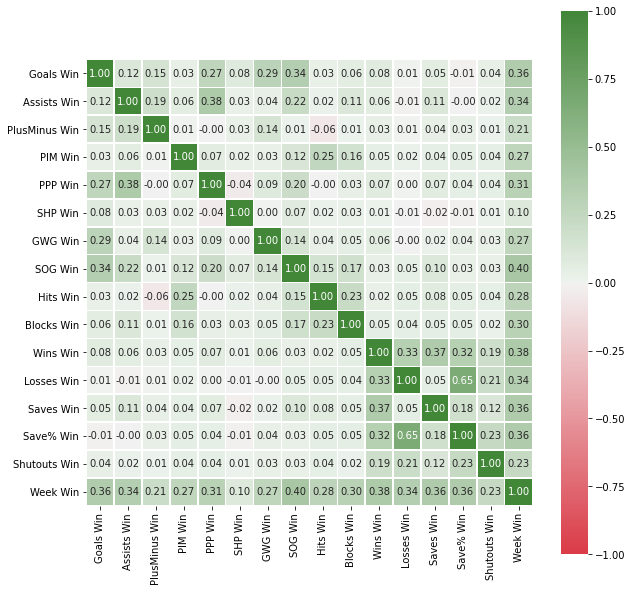

In [ ]:
# Plot correlation heat map
corr = mlDf.corr(method = 'pearson') # kendall and spearmen generate the same results
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 125, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5,fmt='.2f',annot=True)

In [ ]:
mlDf4 = mlDf.copy()


In [ ]:
mlDf4['Offense Win'] = (mlDf['Goals Win'] + mlDf['Assists Win'] + mlDf['PPP Win'] + mlDf['SHP Win'] + mlDf['GWG Win'])
mlDf4['Peripherals Win'] = (mlDf['SOG Win'] + mlDf['Hits Win'] + mlDf['Blocks Win'] + mlDf['PIM Win'] + mlDf['PlusMinus Win'])
mlDf4['Goaltending Win'] = (mlDf['Wins Win'] + mlDf['Losses Win'] + mlDf['Saves Win'] + mlDf['Save% Win'] + mlDf['Shutouts Win'])


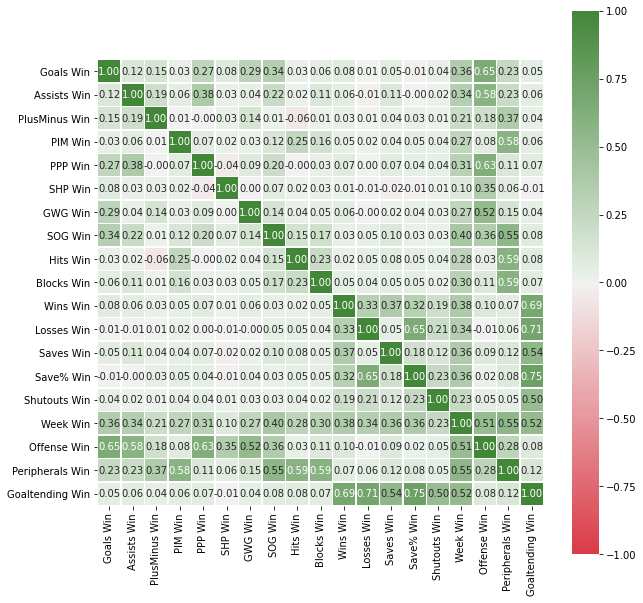

In [ ]:
# Plot correlation heat map
corr = mlDf4.corr(method = 'pearson') # kendall and spearmen generate the same results
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 125, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5,fmt='.2f',annot=True)

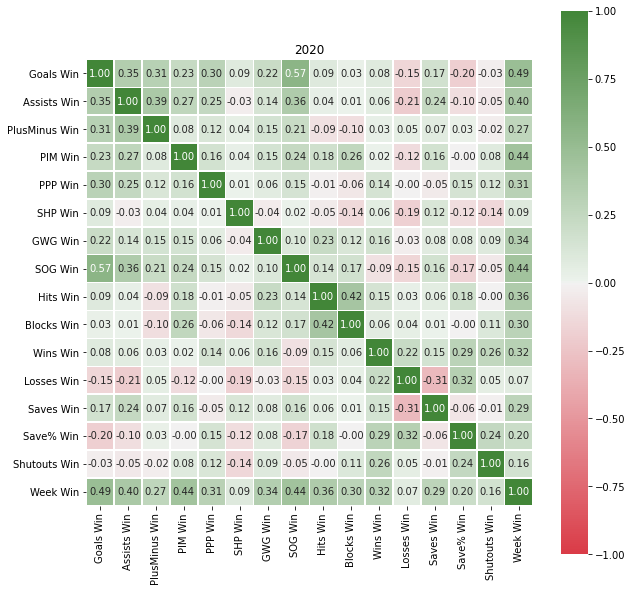

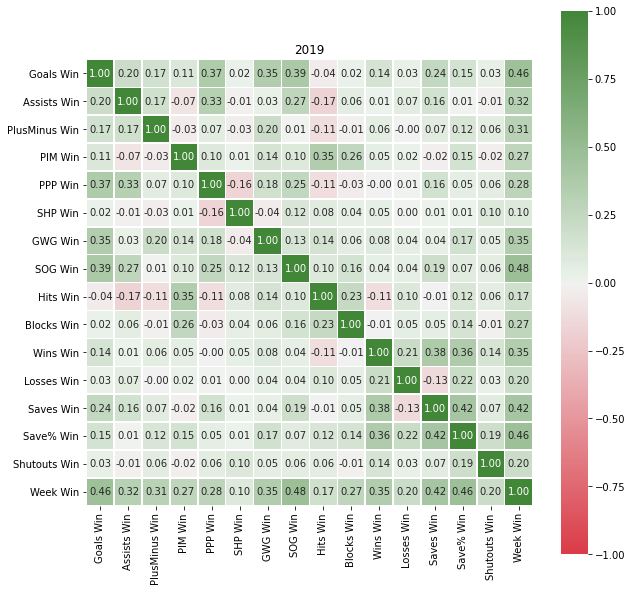

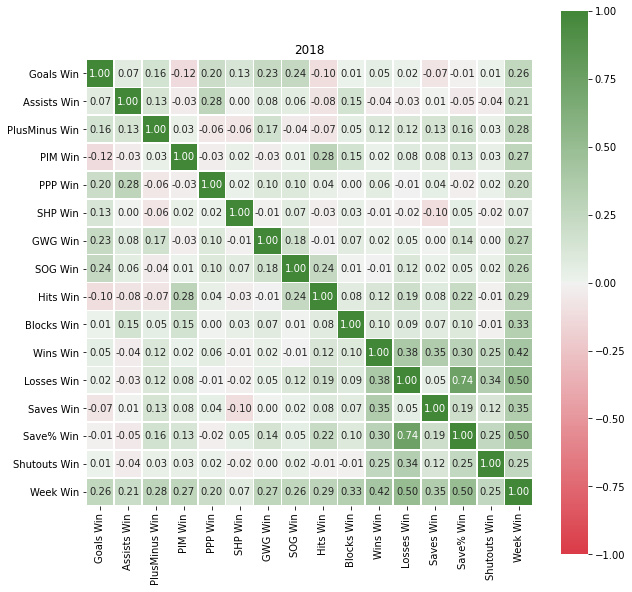

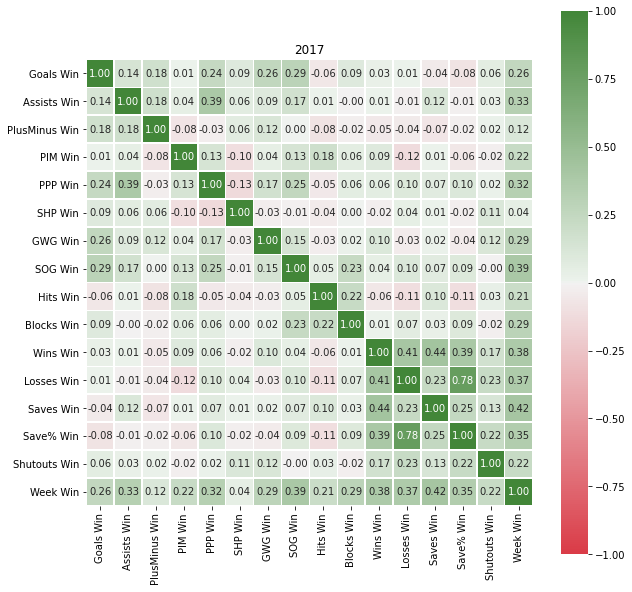

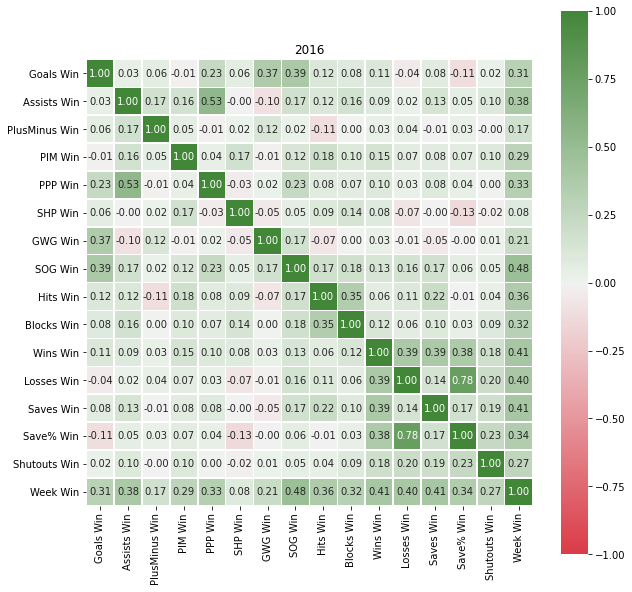

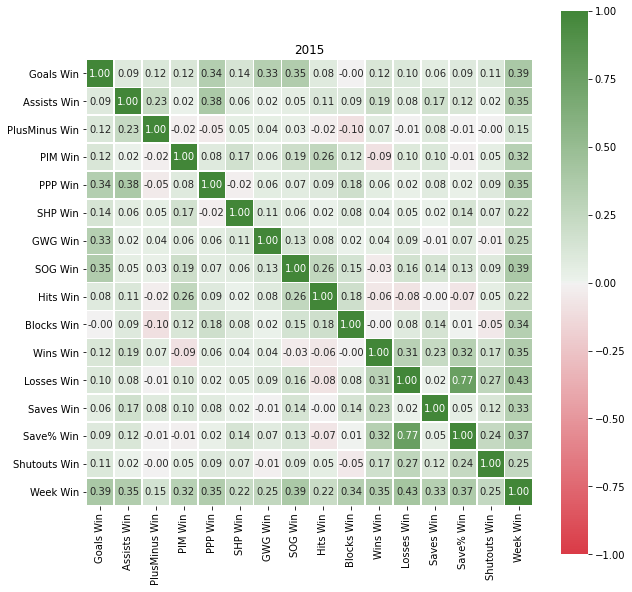

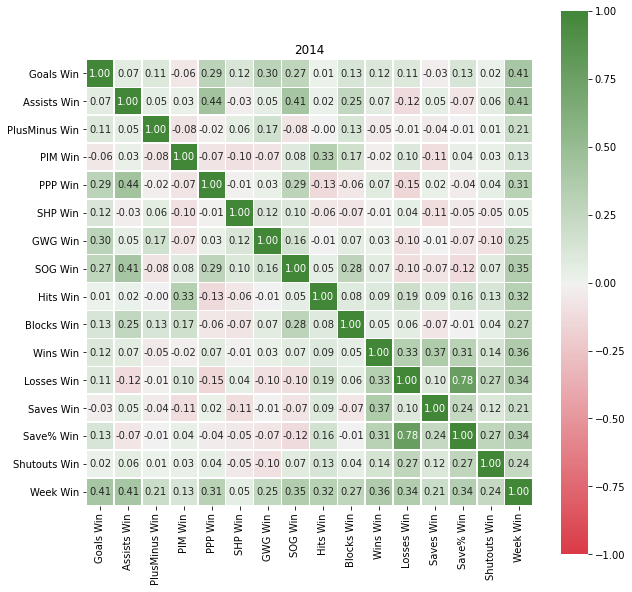

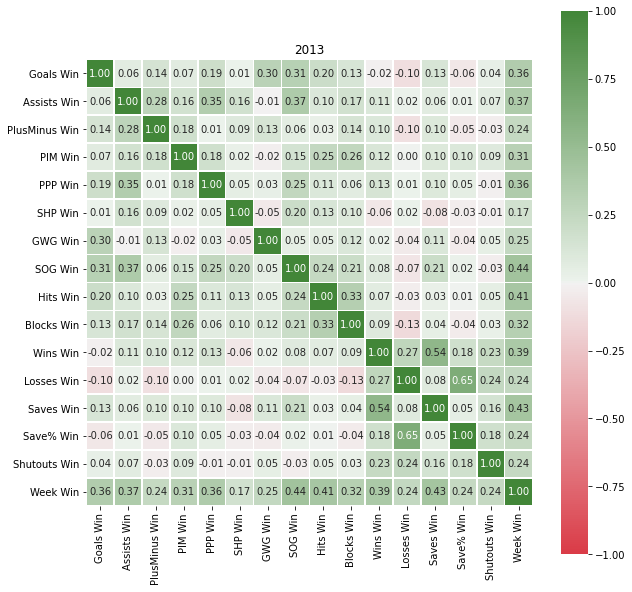

In [ ]:
years = outputDf['Year'].unique()
corrMat = pd.DataFrame()
for year in years:
  mltruncatedDf = outputDf[outputDf['Year']==year]
  mlDf = mltruncatedDf[['Goals Win','Assists Win','PlusMinus Win','PIM Win','PPP Win','SHP Win','GWG Win','SOG Win','Hits Win','Blocks Win','Wins Win','Losses Win','Saves Win','Save% Win','Shutouts Win','Week Win']]
  # Plot correlation heat map
  corr = mlDf.corr(method = 'pearson') # kendall and spearmen generate the same results
  f, ax = plt.subplots(figsize=(10, 10))
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(10, 125, as_cmap=True)
  sns.heatmap(corr, cmap=cmap, vmin=-1,vmax=1, center=0,
              square=True, linewidths=.5,fmt='.2f',annot=True).set_title(year)
  corrMat = pd.concat([corrMat,corr],ignore_index=False)


In [ ]:
Masprint(corrMat)

     Goals Win  Assists Win  PlusMinus Win  ...  Save% Win  Shutouts Win  Week Win
0     1.000000     0.349845       0.314325  ...  -0.195269     -0.028543  0.488921
1     0.349845     1.000000       0.388527  ...  -0.102529     -0.051378  0.395990
2     0.314325     0.388527       1.000000  ...   0.027612     -0.024704  0.267927
3     0.229510     0.266644       0.082579  ...  -0.000429      0.080835  0.442849
4     0.302443     0.246608       0.119262  ...   0.147897      0.122975  0.311148
..         ...          ...            ...  ...        ...           ...       ...
123  -0.104736     0.020874      -0.097307  ...   0.645849      0.242427  0.244052
124   0.132666     0.062622       0.097307  ...   0.048612      0.155846  0.425348
125  -0.056588     0.013482      -0.048944  ...   1.000000      0.176653  0.236455
126   0.035185     0.066147      -0.031052  ...   0.176653      1.000000  0.236780
127   0.355081     0.371599       0.240484  ...   0.236455      0.236780  1.000000

[12

Everything below this cell shall be for investigative purposes only, and will be removed for the final version of the code

In [ ]:
currentLeague.draft_results()
# Can store this as an array and cycle through as needed
# sample output : [{'pick': 1, 'player_id': 7114, 'round': 1, 'team_key': '403.l.32891.t.12'},

In [ ]:
draftRes = currentLeague.draft_results() 
print('Number of players drafted in 2020: ', len(draftRes))

In [ ]:
currentLeague.free_agents('G') # Use '' for all free agents; otherwise RW, C, LW, Util, D, G, IR+
# Can store this as an array and cycle through as needed
# sample output: [{'eligible_positions': ['LW', 'RW', 'Util'],
#                 'name': 'Patrick Marleau',
#                 'percent_owned': 1,
#                 'player_id': 1644,
#                 'position_type': 'P',
#                 'status': ''},

In [ ]:
currentLeague.taken_players() # kind of useless; doesn't give the team info

In [ ]:
playerDirectory = 

In [ ]:
currentFAs = currentLeague.free_agents('')
print('Number of free agents available: ', len(currentFAs))

In [ ]:
currentLeague.ownership([])  # gives a small list of owned players; if you populate the cell bracket with a player ID number, it will give you the owner info
# '1600': {'owner_team_name': "Heuton's Hackers", 'ownership_type': 'team'},

In [ ]:
currentLeague.percent_owned(['3737'])

In [ ]:
currentLeague.player_details('Sidney Crosby')

In [ ]:
import datetime
currentLeague.player_stats([3737],req_type='date', date=datetime.date(year=2021,month=1,day=16))

In [ ]:
 currentLeague.positions()

In [ ]:
currentLeague.settings()

In [ ]:
currentLeague.standings()[15]['name']


In [ ]:
currentLeague.stat_categories()


In [ ]:
currentLeague.team_key()


In [ ]:
currentLeague.teams()


In [ ]:
currentLeague.transactions(tran_types='trade', count='')  # trans_types = add,drop,commish,trade; count = '' for all


In [ ]:
tms = currentLeague.teams()
tms.keys()  # 403.l.32891.t.16 is me

In [ ]:
for tms in currentLeague.teams():
  print(tms)


In [ ]:
import pprint
#test = currentLeague.matchups(6)["fantasy_content"]["league"][1]["scoreboard"]['0']['matchups']['6']#['0']#['teams']#['0']#['team'][0][0]['team_key']
testKey = '386.l.25523.t.9'

In [ ]:
testTeam = currentLeague.to_team(teamKey)

In [ ]:
testTeam.roster()

In [ ]:
currentLeague.matchups()

In [ ]:
sampleKey = currentLeague.matchups(4)["fantasy_content"]["league"][1]["scoreboard"]['0']['matchups']['6']['matchup']#['stat_winners'][10]['stat_winner']['winner_team_key']

In [ ]:
sampleKey

In [ ]:
sampleKey == testKey

True

In [ ]:
currentLeague.matchups(4)["fantasy_content"]["league"][1]["scoreboard"]['0']['matchups']['6']['matchup']['stat_winners'][10]['stat_winner']#['stat_id']

{'is_tied': 1, 'stat_id': '19'}

In [ ]:
weekMatchup["fantasy_content"]["league"][1]["scoreboard"]['0']['matchups']['6']['matchup']['stat_winners'][10]['stat_winner']#['stat_id']

KeyError: ignored

In [ ]:
          currentLeague.matchups(week)["fantasy_content"]["league"][1]["scoreboard"]['0']['matchups']['6']['matchup']['stat_winners'][12]['stat_winner']['winner_team_key']


'403.l.32891.t.12'

In [ ]:
currentLeague.matchups(week)["fantasy_content"]["league"][1]["scoreboard"]['0']['matchups']['6']#['matchup']['stat_winners'][12]['stat_winner']['winner_team_key']

In [ ]:
week

1

In [ ]:
currentMatchups

In [ ]:
currentLeague.player_details(
    'Phil Kessel'
)

In [ ]:
import datetime
x = datetime.date(2018, 12, 7)
print(x)
currentLeague.player_stats([6743],req_type = 'date',date=x)



In [ ]:
currentLeague.matchups(week)["fantasy_content"]["league"][1]["scoreboard"]['0']['matchups']['0']['matchup']['stat_winners']#[14]#['stat_winner']#['winner_team_key']